# Assignment 1 - Regression (normal equation)

In [21]:
# Usual Imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk
import sklearn.model_selection as skms
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

## Part A: Data Cleaning & Exploratory Analysis

In [22]:
data = pd.read_csv("../Data/bottle.csv",low_memory=False)
data.shape

(864863, 74)

In [23]:
extracted_data_1 = data[['T_degC', 'Salnty', 'STheta']]
extracted_data_1 = extracted_data_1.dropna()
extracted_data_1.shape

(812174, 3)

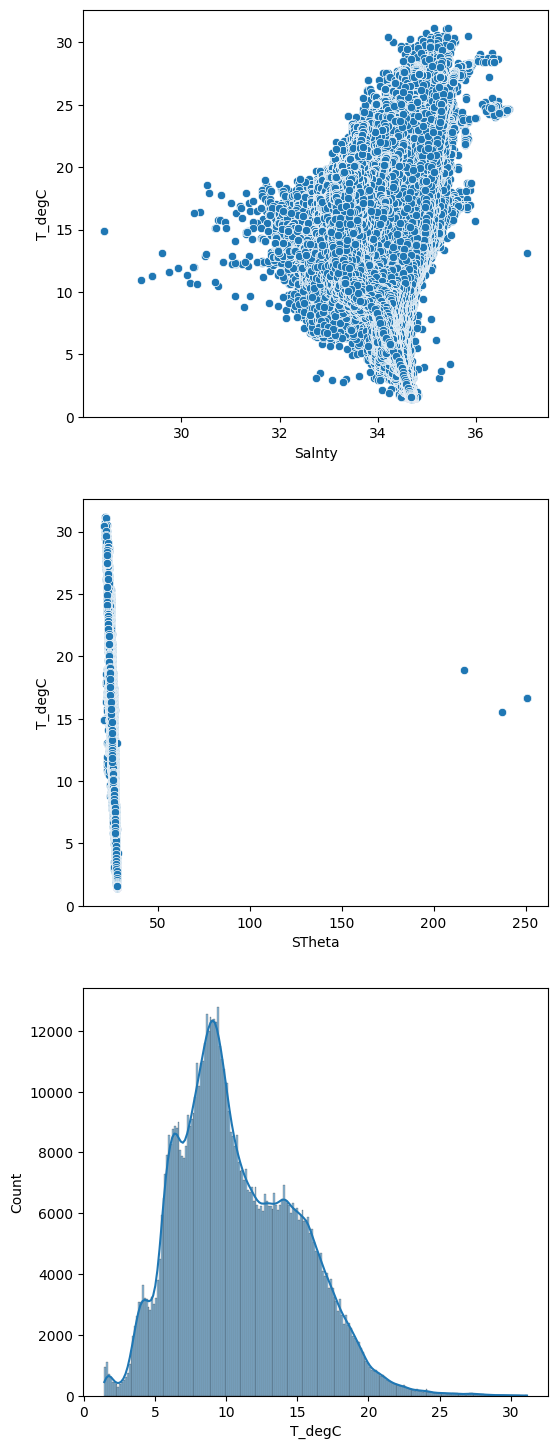

In [24]:
fig_1,axes_1 = plt.subplots(3,1,figsize=(6,18))
sl_t_deg = sns.scatterplot(data=extracted_data_1,x="Salnty",y="T_degC",ax=axes_1[0])
st_t_deg = sns.scatterplot(data=extracted_data_1,x="STheta",y="T_degC",ax=axes_1[1])
t_deg = sns.histplot(data=extracted_data_1,x="T_degC", kde=True,ax=axes_1[2])

In [25]:
extracted_data_2 = extracted_data_1[extracted_data_1["STheta"]<=50]
extracted_data_2.shape

(812168, 3)

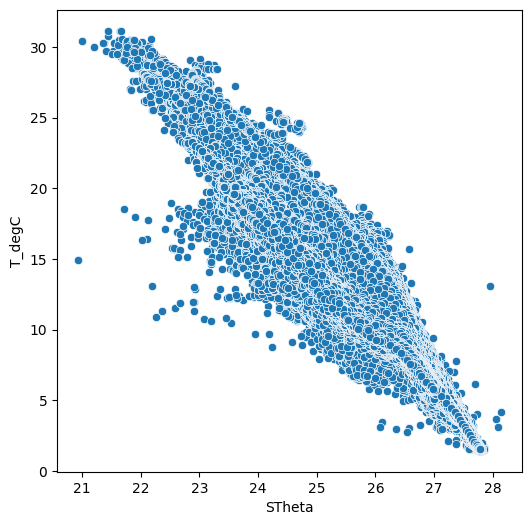

In [26]:
fig_2,axes_2 = plt.subplots(1,1,figsize=(6,6))
st_t_deg = sns.scatterplot(data=extracted_data_2,x="STheta",y="T_degC",ax=axes_2)

As we can see, the removal of the outliers has allowed the data to be better presented on a more suitable scale.

## Part B: Train & Test Split:

In [27]:
X_train,X_test,y_train,y_test = skms.train_test_split(extracted_data_2[["STheta","Salnty"]],extracted_data_2["T_degC"],test_size=0.30, random_state=42)

## Part C: Linear Regression Using Normal Equation - Coded In Python

In [28]:
class NormalLinearRegression:
    
    def fit(self,X,y):
        betas = np.c_[np.ones((X.shape[0], 1)), X]
        self.thetas = np.linalg.inv(betas.T.dot(betas)).dot(betas.T).dot(y)
    def predict(self,X):
        beta_pred = np.c_[np.ones((X.shape[0], 1)), X]
        return beta_pred.dot(self.thetas)


In [29]:
def find_metrics(y_test,y_pred):
    mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
    r2_scores = r2_score(y_true=y_test,y_pred=y_pred)
    exp_var = explained_variance_score(y_true=y_test,y_pred=y_pred)
    return pd.DataFrame({"MSE" : [mse],"R Squared Score": [r2_scores],"Explained Variance": [exp_var]})

In [30]:
norm_lin_reg = NormalLinearRegression()
norm_lin_reg.fit(X_train,y_train)
print(norm_lin_reg.thetas)
norm_y_pred = norm_lin_reg.predict(X_test)
find_metrics(y_test=y_test.values,y_pred=norm_y_pred)

[35.6504482  -5.03872733  3.11107278]


,MSE,R Squared Score,Explained Variance
0,0.233076,0.986922,0.986922


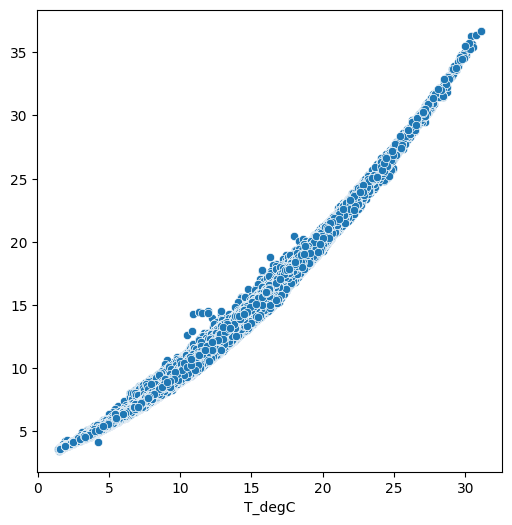

In [31]:
fig_2,axes_2 = plt.subplots(1,1,figsize=(6,6))
st_t_deg = sns.scatterplot(x=y_test,y=norm_y_pred,ax=axes_2)

## Part D: Using sklearn API

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
print(lin_reg.intercept_, lin_reg.coef_)
lin_y_pred = lin_reg.predict(X_test)
find_metrics(y_test=y_test.values,y_pred=lin_y_pred)

35.65044819418292 [-5.03872733  3.11107278]


,MSE,R Squared Score,Explained Variance
0,0.233076,0.986922,0.986922


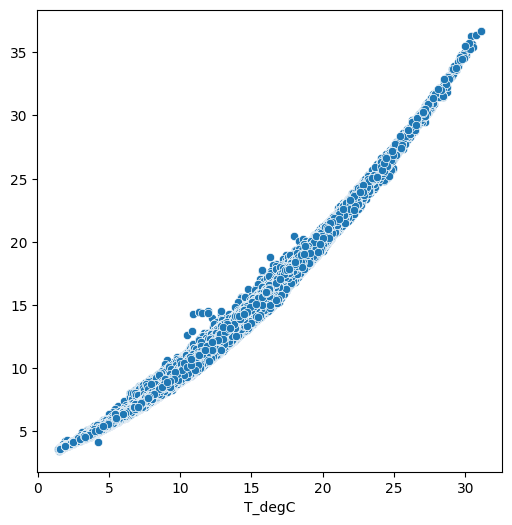

In [33]:
fig_2,axes_2 = plt.subplots(1,1,figsize=(6,6))
st_t_deg = sns.scatterplot(x=y_test,y=lin_y_pred,ax=axes_2)

## Part E: Conceptual Questions

#### 1. Why is it important to have a test set?
Test Sets are important as they can be used to see how well the model performs on _unseen_ data. They provide a way to test against overfitting. Test sets are also useful in testing the performance of multiple models against each other. 

#### 2. If the normal equation always provides a solution, when would we not want to use it?
Finding linear regression co-efficients using normal equation or OLS (Oridinary Least Squares) are usefull when the data size is smaller, but as the alogorithm works in O(n2) time, the more data there is, the longer it will take to minimize the co-efficients. Alternative algorithms like gradient descent solves this issue. The next issue that plagues OLS models, is high variance data. Since the SSE is being optimized, the model tends to fit outlier data points since they will produce higher error values due to the squared term within the loss function. By fitting these outlier points, the OLS model can subsequently base predictions off modeled patterns that are only present in the training data — idiosyncratic outlying points — and not representative of the entire population. This is called overfitting and can lead to models with low predictability. This issue can be minimized by either removing outlier terms (This can cause predictive issues) or by using regularized models like RIDGE. RIDGE works by adding a penalty co-efficient that applies as shrinkage to the overall co-efficient estimates.

#### 3. How might we improve the fit of our models from Part C & D?

Considering our R2 and Explained Variance values are already nearing 1 and our mse is nearing 0, we can see that our model is doing well enough. But if we were to look at imporoving our performance, while including the outliers we had previously removed, we can use RIDGE regression. 

RIDGE regression also known as Tikhonov regularization modifies the OLS normal equation with the addition of an L2 penalty with a tuning parameter lambda. The function can be described as: 

$\left (L\left (\beta \right) = \parallel y-X\beta \parallel_{2}^{2} + \lambda\parallel\beta \parallel_{2}^{2} \right)^{\lambda \geq 0}$

Similar to an OLS equation, the L2 equation can be formulated as a least squares optimization problem:

$\hat{\beta} = arg min_{\beta} L \left ( \beta \right ) =  arg min_{\beta} \frac{1}{2n} \left \| y-X\beta \right \|_{2}^{2} + \lambda\left \| \beta \right \|_{2}^{2}$

A closed-form solution for the Ridge estimator can be found by setting the gradient of the loss function (objective) equal to zero and solving the resultant equation. This produces an estimator result of:

$\hat{\beta} = \left ( X^{T}X + \lambda I \right )^{-1}X^{T}y$

We can see an implementation of the RIDGE regressor below along with the sklearn implementation.

In [34]:
class RIDGELinearRegression:
    
    def fit(self,X,y,l2):
        m, n = np.shape(X)
        top_half = np.hstack((np.ones((m, 1)), X))
        bottom = np.zeros((n, n))
        np.fill_diagonal(bottom, np.sqrt(l2))
        bottom_half = np.hstack((np.zeros((n, 1)), bottom))
        X = np.vstack((top_half, bottom_half))
        y = np.append(y, np.zeros(n))
        self.thetas = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
    def predict(self,X):
        beta_pred = np.c_[np.ones((X.shape[0], 1)), X]
        return beta_pred.dot(self.thetas)


In [38]:
ridge_lin_reg = RIDGELinearRegression()
ridge_lin_reg.fit(X_train,y_train,100)
print(ridge_lin_reg.thetas)
ridge_y_pred = ridge_lin_reg.predict(X_test)
find_metrics(y_test=y_test.values,y_pred=ridge_y_pred)

[35.82442413 -5.0353762   3.10337551]


,MSE,R Squared Score,Explained Variance
0,0.233067,0.986923,0.986923


In [39]:
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X_train,y_train)
print(ridge_reg.intercept_, ridge_reg.coef_)
ridge_reg_y_pred = ridge_reg.predict(X_test)
find_metrics(y_test=y_test.values,y_pred=ridge_y_pred)

35.652191418860646 [-5.03869377  3.11099567]


,MSE,R Squared Score,Explained Variance
0,0.233067,0.986923,0.986923


As we can see, there is barely a change in the Rsquared score, indicating an already matured model. 

#### 4. As we move further into Machine Learning, we will need to continually consider the bias-variance tradeoff. Explain what bias is and what variance is in regards to the bias-variance tradeoff.
**Bias**:
Bias is the difference between the average prediction of our model and the correct value which we are trying to predict. Models with high bias pay very little attention to the training data and oversimplify the models. It always leads to high error on training and test data.

**Variance**:
Variance is the variability of model prediction for a given data point or a value which tells us spread of our data. Model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before. As a result, such models perform very well on training data but has high error rates on test data.

#### 5. In a linear regression model, how might we reduce bias?
We can reduce bias in multiple ways. The most important of which are:
- Normalize the data
- Randomly sample the data
- Choose the correct model for the data provided.
- Methods like cross - validation testing to always avoid training on only a sample of data.

#### 6.In a linear regression model, how might we reduce variance? 
We can reduce variance in multiple ways:
- Ensemble Predictions from Final Models
- Ensemble Parameters from Final Models
- Increase Training Dataset Size
- Cross Validation testing